# Quantum state tomography

In [2]:
import numpy as np
import qiskit.quantum_info as qi
import qiskit.circuit as qc
import qiskit_aer as aer
import qiskit_aer.noise as noise
from qiskit_ibm_runtime import QiskitRuntimeService
import itertools as it
from tqdm import tqdm


import matplotlib.pyplot as plt
import scipy as sy
from qiskit.visualization import plot_histogram

from math import sqrt, log



In [3]:
from src.qu_utils import *
from src.py_utils import *
from src.ML_utils import *
from src.circuit_logic import *
from src.tomography import *


np.random.seed(42)

In [21]:
n = 3
rhotilde = multi_qubits_lin_tomography(n, nshots=100000, noise=True, valid=False)
qi.state_fidelity(rhotilde, theoritical_GHZ(n), validate=False)

100%|██████████| 63/63 [00:19<00:00,  3.19it/s]


0.8595902105781424

In [22]:

backends = ['ibm_brisbane', 'ibm_sherbrooke', 'ibm_kyiv']

noisy_QASM_Brisbane = get_noisy_QASM('ibm_brisbane')
noisy_QASM_Sherbrooke = get_noisy_QASM('ibm_sherbrooke')
noisy_QASM_Kyiv = get_noisy_QASM('ibm_kyiv')
QASM_simu = aer.QasmSimulator()

# nshots = np.arange(100, 30001, 100)
# nshots = np.arange(1000, 20000, 2000)
# nshots = np.concatenate((np.arange(100, 3000, 300), np.arange(5000, 100000, 5000)))
nshots = np.arange(1, 101, 20)
for i in [6]:    
    fidelities = []
    noisy_fidelities_Brisbane = []    
    noisy_fidelities_Sherbrooke = []    
    noisy_fidelities_Kyiv = []    
    for j in tqdm(nshots):
        GHZ = theoritical_GHZ(i)
        
        rhotilde = multi_qubits_lin_tomography(i, nshots=j, simulator=QASM_simu, verbose=False)
        fidelities.append(qi.state_fidelity(rhotilde, GHZ, validate=False))

        noisy_rhotilde_Brisbane = multi_qubits_lin_tomography(i, nshots=j, simulator=noisy_QASM_Brisbane, verbose=False)
        noisy_fidelities_Brisbane.append(qi.state_fidelity(noisy_rhotilde_Brisbane, GHZ, validate=False))

        noisy_rhotilde_Sherbrooke = multi_qubits_lin_tomography(i, nshots=j, simulator=noisy_QASM_Sherbrooke, verbose=False)
        noisy_fidelities_Sherbrooke.append(qi.state_fidelity(noisy_rhotilde_Sherbrooke, GHZ, validate=False))
        # noisy_fidelities_Sherbrooke.append(0)

        noisy_rhotilde_Kyiv = multi_qubits_lin_tomography(i, nshots=j, simulator=noisy_QASM_Kyiv, verbose=False)
        noisy_fidelities_Kyiv.append(qi.state_fidelity(noisy_rhotilde_Kyiv, GHZ, validate=False))
        # noisy_fidelities_Kyiv.append(0)
    
    with open(f'data/fidelities_n={i}_range={int(nshots[0])}_{int(nshots[1]-nshots[0])}_{int(nshots[-1])}_log.dat', 'w') as f:
        np.savetxt(f, np.column_stack((nshots, fidelities, noisy_fidelities_Brisbane, noisy_fidelities_Sherbrooke, noisy_fidelities_Kyiv)))



 40%|████      | 2/5 [1:03:02<1:34:34, 1891.36s/it]


KeyboardInterrupt: 

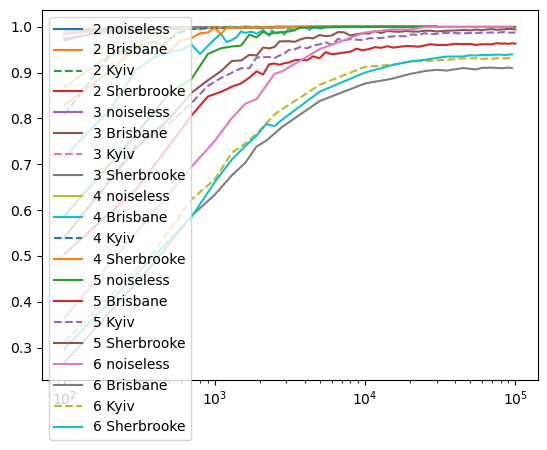

In [17]:

# nshots = np.arange(100, 1000, 100)
for i in range(2, 7):
    fn = f'data/fidelities_n={i}_range={100}_{100}_{30000}.dat' 
    if i==4:
        fn = f'data/fidelities_n={i}_range={100}_{100}_{30000}_log.dat' 
    elif i==5:
        fn = f'data/fidelities_n={i}_range={100}_{200}_{30000}_{35000}_{5000}_{100000}_log.dat' 
    elif i==6:
        fn = f'data/fidelities_n={i}_range={100}_{300}_{95000}_log.dat' 

    with open(fn, 'r') as f:
        data = np.loadtxt(f)
        nshots = data[:, 0]
        fidelities = data[:, 1]
        noisy_fidelities_Brisbane = data[:, 2]
        noisy_fidelities_Sherbrooke = data[:, 3]
        noisy_fidelities_Kyiv = data[:, 4]
    plt.plot(nshots, fidelities, label=f'{i} noiseless')
    plt.plot(nshots, noisy_fidelities_Brisbane, label=f'{i} Brisbane')
    plt.plot(nshots, noisy_fidelities_Kyiv, '--', label=f'{i} Kyiv')
    plt.plot(nshots, noisy_fidelities_Sherbrooke, label=f'{i} Sherbrooke')
    plt.xscale('log')
plt.legend()


# Classical shadows

In [4]:

def single_measurement_clifford(n, op, nshots, simulator):
    circuit = init_GHZ(n)
    measurement_in_clifford_basis(circuit, op)
    counts = run_circuit(simulator, circuit, nshots).get_counts()#, method="stabilizer")
    return counts


def measurement_in_clifford_basis(circuit, clifford_op):
    gate = clifford_op.to_circuit()

    circuit.compose(gate, inplace=True)

    circuit.measure_all(add_bits=False)


def measurement_to_fidelity(n, outcomes):
    GHZ = init_GHZ(n)
    amplitudes = np.zeros(len(outcomes))
    for i, outcome in enumerate(outcomes):
        rotated_GHZ = GHZ.compose(outcome['clifford'].to_circuit())
        stabilizer_circuit = qi.StabilizerState(rotated_GHZ)
        amplitude = stabilizer_circuit.probabilities_dict_from_bitstring(outcome_bitstring=outcome['bitstring'])
        amplitudes[i] = list(amplitude.values())[0]
    return (2**n+1)*amplitudes-1


def classical_shadow_bis_efficient(n, N, noise=False, nshots=1, simulator=None, verbose=True):
    outcomes = []
    if not simulator:
        if noise:
            simulator = get_noisy_QASM()
        else:
            simulator = aer.QasmSimulator()

    for i in tqdm(range(N), disable=(not verbose)):
        # print('cc', n)
        clifford_op = qi.random_clifford(int(n))
        if nshots>1:
            counts = single_measurement_clifford(n, clifford_op, nshots=nshots, simulator=simulator)
            # keep only the highest val.
            counts = {max(counts, key=counts.get): counts[max(counts, key= counts.get)]}
        else:
            counts = single_measurement_clifford(n, clifford_op, nshots=1, simulator=simulator)
        bitstring = list(counts.keys())[0]
        # print(counts)
        outcomes.append({'clifford': clifford_op, 'bitstring': bitstring})

    return measurement_to_fidelity(n, outcomes)




def median_of_means_fidelity(cl_shadow, K):
    N = len(cl_shadow)
    # if K>N/2:
    #     K = N//2
    # rhos = [qi.state_fidelity(init_state, np.mean(cl_shadow[(k-1)*N//K+1:k*N//K], axis=0), validate=False) for k in range(1, K+1)]
    fidelities = np.zeros(K)
    for k in range(1, K+1):
        fidelities[k-1] = np.mean(cl_shadow[(k-1)*N//K:k*N//K+1])
    
    # print(f'fidelities: {fidelities}')
    return np.median(fidelities)


In [4]:
n = 50
test = classical_shadow_bis_efficient(n, 1000, noise=False)
# print(test)
# median_of_means_fidelity_efficient(test, 10)

  9%|▊         | 86/1000 [00:03<00:37, 24.69it/s]


KeyboardInterrupt: 

In [299]:
median_of_means_fidelity_efficient(test, 10)

0.9985029940119761

In [5]:
noisy_QASM_Brisbane = get_noisy_QASM('ibm_brisbane')
QASM_simu = aer.QasmSimulator()

In [16]:
# ns = np.concatenate((np.arange(3, 16), np.arange(20, 101, 20)))
ns = [4, 6]
N = 8000
for n in tqdm(ns):
    print(n, N)
    def filename(simu):
        return f'data/fidelities_n={n}_N={N}_{simu}_bis.dat'
    
    fidelities = []
    noisy_fidelities_Brisbane = []    
    noisy_fidelities_Sherbrooke = []    
    noisy_fidelities_Kyiv = []   

    shadows = classical_shadow_bis_efficient(n, N, simulator=QASM_simu)
    fidelities.append(shadows)

    fn = filename('QASM')
    with open(fn, 'w') as f:
        np.savetxt(f, fidelities)
    print(f'{fn} saved')

    noisy_shadows_Brisbane = classical_shadow_bis_efficient(n, N, simulator=noisy_QASM_Brisbane)
    noisy_fidelities_Brisbane.append(noisy_shadows_Brisbane)

    fn = filename('Br')
    with open(fn, 'w') as f:
        np.savetxt(f, noisy_fidelities_Brisbane)
    print(f'{fn} saved')

    # noisy_shadows_Sherbrooke = classical_shadow_bis_efficient(n, N, simulator=noisy_QASM_Sherbrooke)
    # noisy_fidelities_Sherbrooke.append(noisy_shadows_Sherbrooke)

    # noisy_shadows_Kyiv = classical_shadow_bis_efficient(n, N, simulator=noisy_QASM_Kyiv)
    # noisy_fidelities_Kyiv.append(noisy_shadows_Kyiv)

    


  0%|          | 0/2 [00:00<?, ?it/s]

4 8000


100%|██████████| 8000/8000 [00:12<00:00, 627.26it/s]


data/fidelities_n=4_N=8000_QASM_bis.dat saved


 50%|█████     | 1/2 [1:31:09<1:31:09, 5469.35s/it]

data/fidelities_n=4_N=8000_Br_bis.dat saved
6 8000


100%|██████████| 8000/8000 [00:15<00:00, 512.27it/s]


data/fidelities_n=6_N=8000_QASM_bis.dat saved


100%|██████████| 2/2 [2:57:26<00:00, 5323.14s/it]  

data/fidelities_n=6_N=8000_Br_bis.dat saved


# Comparison times

In [5]:
import time
import json
QASM_simu = aer.QasmSimulator()

N = 5000
K = 20
nshots = 5000

nqubits = np.arange(2, 12)
time_meas_tomo = {}
time_meas_clsh = {}
time_tot_tomo = {}
time_tot_clsh = {}
fidelities_tomo = {}
fidelities_clsh = {}
for n in nqubits:
    GHZ = theoritical_GHZ(n)
    
    if n<8:
        start_tomo = time.time()
        rhotilde = multi_qubits_lin_tomography(n, nshots=nshots, simulator=QASM_simu, verbose=True, valid=False)
        end_meas_tomo = time.time()
        fidelities_tomo[n] = qi.state_fidelity(make_it_semi_positive_definite(rhotilde), GHZ, validate=False)
        end_tot_tomo = time.time()

        time_meas_tomo[n] = end_meas_tomo-start_tomo
        time_tot_tomo[n] = end_tot_tomo-start_tomo
 
    start_clsh = time.time()
    shadows = classical_shadow_bis_efficient(n, N, simulator=QASM_simu)
    end_meas_clsh = time.time()
    fidelities_clsh[n] = median_of_means_fidelity(shadows, K)
    end_tot_clsh = time.time()

    time_meas_clsh[n] = end_meas_clsh-start_clsh
    time_tot_clsh[n] = end_tot_clsh-start_clsh

all_ = [time_meas_tomo, time_meas_clsh, time_tot_tomo, time_tot_clsh, fidelities_tomo, fidelities_clsh]
all_fn = ['time_meas_tomo', 'time_meas_clsh', 'time_tot_tomo', 'time_tot_clsh', 'fidelities_tomo', 'fidelities_clsh']

for el, name in zip(all_, all_fn):
    el = {int(key): val for key, val in el.items()}
    with open(f'data/{name}_{min(nqubits)}_{max(nqubits)}.json', 'w') as f:
        json.dump(el, f)

100%|██████████| 5000/5000 [00:23<00:00, 217.32it/s]


In [18]:
fidelities_tomo

{2: 0.9998898295837835,
 3: 0.9996603972249813,
 4: 0.9997329519675205,
 5: 0.9993724475485491,
 6: 0.9520924275189936,
 7: 0.7823229628136805}

In [19]:
time_meas_tomo

{2: 0.047392845153808594,
 3: 0.17718124389648438,
 4: 0.6977510452270508,
 5: 3.1736629009246826,
 6: 11.864299058914185,
 7: 43.29245162010193}

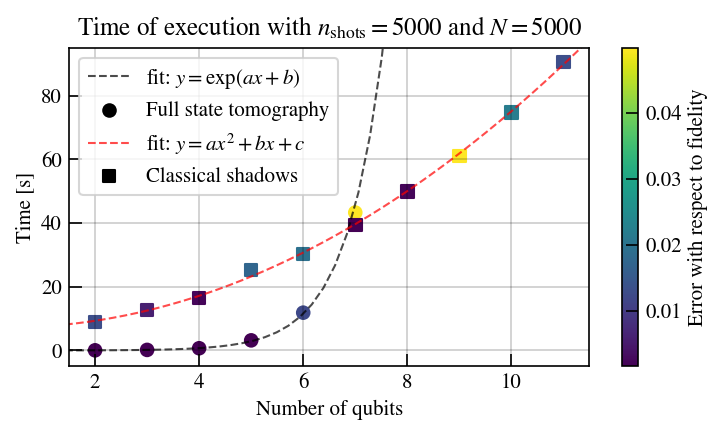

In [58]:
plt.style.use('style_v1.mplstyle')
names = ['Full state tomography', 'Classical shadows']
shape = ['o', 's']
colors = ['k', 'r']
x = np.linspace(1, 12)
for i in range(2):#in zip(all_[:2], names):
    if names[i]=='Classical shadows':
        fit = np.polyfit(list(all_[i].keys()), list(all_[i].values()), 2)
        vals = np.polyval(fit, x)
        label = r'fit: $y=ax^2+bx+c$'
    else:
        fit = np.polyfit(list(all_[i].keys()), np.log(list(all_[i].values())), 1)
        vals = np.polyval(fit, x)
        vals = np.exp(vals)
        label = r'fit: $y=\exp(ax+b)$'
        
    plt.plot(x, vals, '--', color=colors[i], label=label, alpha=0.7)
    plt.scatter(0, 0, c='k', label=names[i], marker=shape[i])
    plt.scatter(all_[i].keys(), all_[i].values(), c=np.abs(np.array(list(all_[i+4].values()))-1), marker=shape[i])#, label=names[i])


plt.xlabel('Number of qubits')
plt.ylabel('Time [s]')
plt.grid()
plt.xlim(1.5, 11.5)
plt.ylim(-5, 95)
plt.colorbar(label='Error with respect to fidelity')
plt.legend()
plt.title(r'Time of execution with $n_{\text{shots}}=5000$ and $N=5000$')
plt.tight_layout()
plt.savefig('plots/exec_time.pdf')